In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For Directml Gpu Configurations
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

# # Font update global for all plots
# plt.rcParams.update({"font.size": 18})

In [2]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=";")
data = data[data["total sulfur dioxide"] < 200]  # drop a few outliers
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop("quality")

In [3]:
def createUnbalancedData(threshold=5):
    # z-score all columns except for quality

    data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

    # Binalizing quality field
    data["boolQuality"] = 0
    data.loc[data["quality"] >= threshold, "boolQuality"] = 1

    # convert from pandas dataframe to tensor
    dataT = torch.tensor(data[cols2zscore].values).float()
    labels = torch.tensor(data["boolQuality"].values).float()
    # transform to matrix
    labels = labels.reshape(labels.shape[0], 1)
    # use scikitlearn to split the data
    train_data, test_data, train_labels, test_labels = train_test_split(
        dataT, labels, test_size=0.1
    )

    # then convert them into PyTorch Datasets (note: already converted to tensors)
    train_data = TensorDataset(train_data, train_labels)
    test_data = TensorDataset(test_data, test_labels)
    # finally, translate into dataloader objects
    batchsize = 8
    train_loader = DataLoader(
        train_data,
        batch_size=batchsize,
        shuffle=True,
        drop_last=True,
        generator=torch.Generator(device),
    )
    test_loader = DataLoader(
        test_data,
        batch_size=test_data.tensors[0].shape[0],
        generator=torch.Generator(device),
    )
    return train_loader, test_loader

In [4]:
# Test the create unbalance data function
train_loader, test_loader = createUnbalancedData(threshold=6)

In [5]:
# Class to create a model
def createWineNet():
    # Model definition
    class ANNwine(nn.Module):
        def __init__(self):
            super().__init__()
            #### Layers
            # Input
            self.input = nn.Linear(11, 32)

            # Hidden
            self.fc1 = nn.Linear(32, 64)
            self.fc2 = nn.Linear(64, 64)

            # Output
            self.output = nn.Linear(64, 1)

            # Forward Function

        def forward(self, x):

            x = F.leaky_relu(self.input(x))
            x = F.leaky_relu(self.fc1(x))
            x = F.leaky_relu(self.fc2(x))

            return self.output(x)

    net = ANNwine()
    # Loss Function
    lossFun = nn.BCEWithLogitsLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossFun, optimizer

In [6]:
# Let's test the model
net, lossFun, optimizer = createWineNet()

net(torch.randn(10, 11)).shape
print(lossFun)
print(optimizer)

BCEWithLogitsLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [7]:
# A function to train the model
def trainTheModel():
    nEpochs = 500
    # Model class Instantiation
    net, lossFun, optimizer = createWineNet()

    # Initiallize losses, train and test accuricies
    losses = torch.zeros(nEpochs)
    trainAcc = []
    testAcc = []

    # The loop
    for epoch in range(nEpochs):
        # Training mode
        net.train()

        # Initialize batch accuricies and losses
        batchAcc = []
        batchLoss = []

        # The batch loop
        for X, y in train_loader:

            # Forward pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch loss
            batchLoss.append(loss.cpu().item())

            # Batch Accuracy
            batchAcc.append(100 * torch.mean(((yHat > 0) == y).float()).cpu().item())

        # End of batch loop
        # Train Accuracy for the epoch
        trainAcc.append(np.mean(batchAcc))
        # Losses across the batches
        losses[epoch] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X, y = next(iter(test_loader))  # extract X,y from test dataloader
        with torch.no_grad():  # deactivates autograd
            yHat = net(X)
        testAcc.append(100 * torch.mean(((yHat > 0) == y).float()).cpu().item())
    # Function output
    return trainAcc, testAcc, losses, net

Training started for: 4.5
Training started for: 5.5
Training started for: 6.5


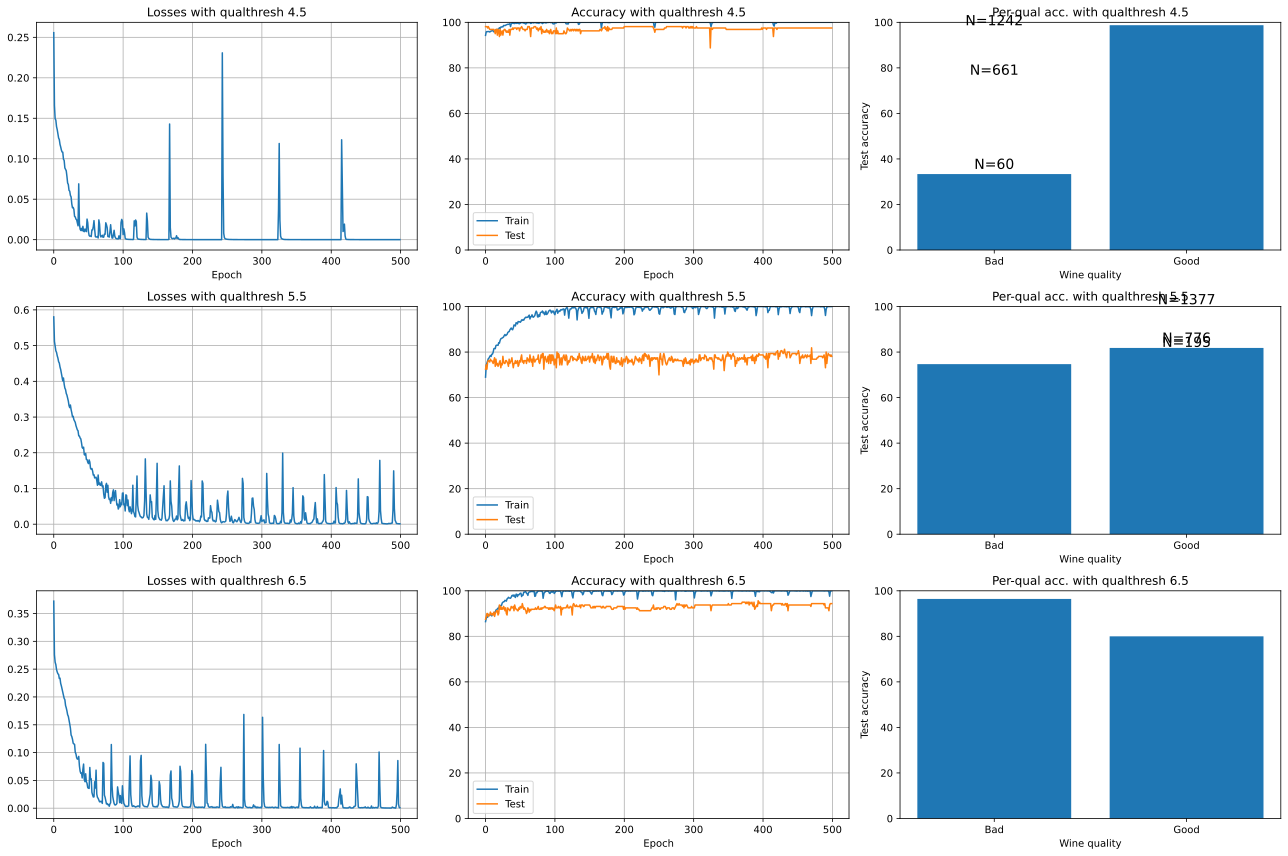

In [26]:
#### The Experiment
fig, ax = plt.subplots(3, 3, figsize=(18, 12))
# Params for the Experiment
therosholds = [4.5, 5.5, 6.5]


for i, th in enumerate(therosholds):
    print(f"Training started for: {th}")
    train_loader, test_loader = createUnbalancedData(threshold=th)
    trainAcc, testAcc, losses, net = trainTheModel()

    # compute accuracy per quality type
    X, y = next(iter(test_loader))
    itemAccuracy = ((net(X) > 0) == y).float().cpu()

    perQualAcc = [
        100 * torch.mean(itemAccuracy[y.cpu() == 0]),
        100 * torch.mean(itemAccuracy[y.cpu() == 1]),
    ]
    # Plot Loss
    ax[i][0].plot(losses.cpu())
    ax[i][0].set_title("Losses with qualthresh " + str(th))
    ax[i][0].set_xlabel("Epoch")
    ax[i][0].grid()

    # plot overall accuracy
    ax[i][1].plot(trainAcc, label="Train")
    ax[i][1].plot(testAcc, label="Test")
    ax[i][1].set_title("Accuracy with qualthresh " + str(th))
    ax[i][1].legend()
    ax[i][1].set_xlabel("Epoch")
    ax[i][1].set_ylim([0, 100])
    ax[i][1].grid()

    # plot the per-quality accuracy
    bh = ax[i][2].bar(["Bad", "Good"], perQualAcc)
    ax[i][2].set_ylim([0, 100])
    ax[i][2].set_xlabel("Wine quality")
    ax[i][2].set_ylabel("Test accuracy")
    ax[i][2].set_title("Per-qual acc. with qualthresh " + str(th))
    # print the counts on top of each bar
    for i, r in enumerate(bh):
        N = torch.sum(train_loader.dataset.tensors[1] == i).item()
        ax[i][2].text(
            r.get_x() + r.get_width() / 2,
            r.get_height() + 1,
            "N=%s" % N,
            ha="center",
            va="bottom",
            fontsize=14,
        )

plt.tight_layout()
plt.show()